# PyTorch QuickGuide

Author: Kellen Sullivan

This is a quick guide for how to load in pre-built models provided by PyTorch to train and deploy on your own on dataset. If you are interested in learning all the PyTorch basics, and how to build your very own model, checkout the official PyTorch begineers guide [here](https://docs.pytorch.org/tutorials/beginner/basics/intro.html).

## Getting Started
To get started using PyTorch, you first have to install it! To do so, open a new terminal and run the following command:

- If you are on Windows/Mac: `pip3 install torch torchvision`
- If you are on Linux: `pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cpu`

Note that these commands will use your CPU as the compute platform. If you have an NVIDIA GPU, you can install PyTorch with CUDA as the compute platform to greatly speed up training. Check out the official installation guide to learn more: https://pytorch.org/get-started/locally/

You can confirm PyTorch was successfully installed by importing the package and printing out its version.

In [1]:
import torch

print(torch.__version__)

2.8.0+cpu


## Loading a Prebuilt Model

PyTorch has libraries such as [torchvision](https://docs.pytorch.org/vision/0.8/models.html), [torchaudio](https://docs.pytorch.org/audio/stable/models.html), and [torchtext](https://docs.pytorch.org/text/stable/models.html) that provide prebuilt models to quickly process image data, audio data, or text data. In this quickguide, we will use a prebuilt model from torchvision to classify images into 1 of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. 

### Datasets

Before we load in a prebuilt model, we need to get data. Thankfully torchvision provides datasets that can be easily accessed to train neural networks in PyTorch, including the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset that we will be training a model on!

To load in the CIFAR-10 dataset, we can use the code in the following cell. Note that the CIFAR-10 dataset contains 32x32 pixel images, but the prebuilt models from torchvision expect 224x224 pixel images. Thus we define a transform and apply it to the CIFAR-10 images so that the prebuilt models will work with our data.  

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images: 32x32 -> 224x224
    transforms.ToTensor()
])

training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

To check that we successfully loaded the data, let's print a random example image from the training dataset.

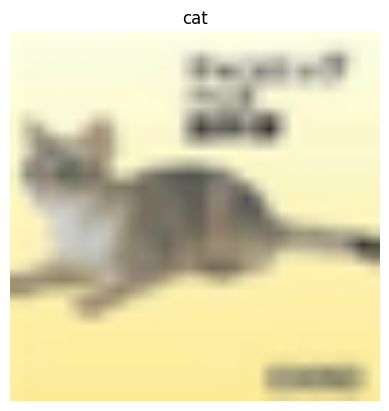

In [3]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(training_data) - 1)
img, label = training_data[idx]

# show image
plt.imshow(img.permute(1, 2, 0))
plt.title(training_data.classes[label])
plt.axis("off")
plt.show()

### Dataloader

When training and testing the model, we will repeatedly need to iterate through our datasets, optimally in batches. Thankfully, PyTorch provides DataLoaders to make this process easy.

The following code creates two DataLoaders, one for the training data and one for the testing data.

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

### Prebuilt Models

Now that we have loaded our data and can iterate through it, we can load in our pre-built model! You can read about many different prebuilt models provided by torchvision [here](https://docs.pytorch.org/vision/0.9/models.html). For this quickguide we will use the resnet18 model due to its moderate size and robust feature extraction capabilities.  

In [5]:
import torchvision.models as models
import torch.nn as nn

resnet_model = models.resnet18(weights=None)

You can view the structure of any PyTorch model by simply printing it

In [8]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Notice that by default, the ResNet18 model’s final layer is defined as the following: 

`(fc): Linear(in_features=512, out_features=1000, bias=True)`

Since the CIFAR-10 dataset has only 10 classes, we need to adjust the final layer so the model produces 10 output scores instead of the default 1000. We can do this by replacing the last layer with a new fully connected layer that maps the same 512 input features to 10 output nodes:

In [ ]:
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)  # overwrite resnet_model.fc layer to have 10 output scores

print(resnet_model)

The final layer should now have 10 outputs, matching the exact structure we need to classify CIFAR-10 images!

## Train a Model

Our ResNet18 model contains over 11 million parameters that influence how the model classifies images. In order for the model to accurately classify images, it must learn the optimal values for those parameters through training. 

Before we can train our model, we need to define two key components: a loss function and an optimizer.
- The [loss function](https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#loss-function) measures how far the model’s predictions are from the correct labels. The lower the loss, the better the model is performing.
- The [optimizer](https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#optimizer) updates the model’s parameters based on the loss, nudging them in directions that reduce future errors. It uses an algorithm called backpropagation to compute how much each parameter contributed to the loss and how it should be adjusted.

In [ ]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001) # lr: learning rate affects how quickly the model adjusts parameters

We train the model by iterating over all the images in our training dataset. For each batch of images and their corresponding labels:
1. We reset the gradients using `optimizer.zero_grad()` so updates from previous batches don’t accumulate.
2. We pass the images through the model to get predictions.
3. We calculate the loss between the predictions and true labels.
4. We backpropagate the loss using `loss.backward()`, which computes how each parameter should change.
5. We update the model parameters with `optimizer.step()`.

Over many iterations, the model gradually adjusts its 11 million+ parameters to improve its predictions.

In [ ]:
running_loss = 0.0
for i, (images, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = resnet_model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    # Track running loss
    running_loss += loss.item()
    if (i + 1) % 500 == 0:  # print every 500 mini-batches 
        print(f"[Batch {i+1:5d}] loss: {running_loss / 500:.4f}")
        running_loss = 0.0

print("Finished Training")

If you want to learn more about how gradients and backpropagation work, check out the [PyTorch Optimization Tutorial](https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

## Evaluate a Model

After training, we can measure how well our model performs on unseen data using the test set. The test loader provides batches of images and labels, which we pass through the model to get predictions. We then compare those predictions to the true labels to calculate overall accuracy.

In [ ]:
correct, total = 0, 0
resnet_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test accuracy: {100 * correct / total:.2f}%")

## Save a Model

Once training is complete, you can save your model so it can be reused later without retraining. There are two common ways to save models in PyTorch:
1. Save the entire model (architecture + weights):

In [ ]:
torch.save(resnet_model, 'model.pth') # save model to model.pth file

resnet_model = torch.load('model.pth', weights_only=False) # load full model using model.pth

This approach is useful for quick experiments or short-term work where you’ll reload the model in the same environment. It saves both the model’s structure and weights, so you don’t need to redefine the architecture when loading.

2. Save only the model weights

In [ ]:
torch.save(resnet_model.state_dict(), 'model_weights.pth') # save model weights to model_weights.pth

new_model = models.resnet18()
new_model.fc = nn.Linear(new_model.fc.in_features, 10)  # ensure new_model has same structure as resent_model
new_model.load_state_dict(torch.load('model_weights.pth', weights_only=True)) # load model weights into new model

Saving only the model weights is the standard practice for deployment and model sharing. It produces a smaller, more portable file that works across different systems and PyTorch versions. However, using this approach requires slightly more setup since you must manually recreate the same model architecture before loading the weights.

## Conclusion and Further Readings

Congratulations for completing the PyTorch Quick Guide! 🎓🎉 You now have the skills to load, train, and test a PyTorch Model! 

If you want to learn all the PyTorch basics, check out some of these resources:
- [Official PyTorch Begineers Guide](https://docs.pytorch.org/tutorials/beginner/basics/intro.html).
- [Deep Learning with PyTorch: A 60 Minute Blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)